<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Algorithm 6 - Decision Tree Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 1: Malawi Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  
&nbsp;&nbsp;&nbsp;[Explanation and Theory](#introduction-theory)  
&nbsp;&nbsp;&nbsp;[Considerations](#introduction-considerations)  
[Data Setup](#setup)  
[Scikit-Learn Decision Tree Classifier](#sklearn-dt)  
&nbsp;&nbsp;&nbsp;[Include All Features](#all-feats)  
&nbsp;&nbsp;&nbsp;[Tune Parameters and Cross-Validate](#tune-cv)   
[AdaBoost](#ada-boost)  
[Feature Selection](#feature-selection)  
[Summary](#summary)

# Decision Tree Classifier Introduction <a class="anchor" id="introduction"></a>

Decision trees are a family of nonparametric discriminative learning models that map inputs to classes (or regressed values) using a series of binary questions. Possible answers to the questions form a tree-like flow-chart or data structure that can be efficiently trained and stored. Effectively, decision trees [partition](https://en.wikipedia.org/wiki/Space_partitioning) the space of the training set into many non-overlapping regions. A new data point is then compared to the training points in its region, the tree assigns a class value using majority vote: if my new point lies in a region with 3 red and 4 blue training examples, it will be classified as blue. Decision trees are simple, limited models, but can become quite powerful when combined with additional statistical techniques, as we will explore in the next few  notebooks.

## Explanation and Theory <a class="anchor" id="introduction-theory"></a>

**Assumptions and properties.** It is not necessary to make any assumptions about the underlying distribution of the empirical data in order to successfully train a decision tree. Further, one of the most attractive features of decision tree models is that a single tree can easily handle _mixed predictors_. In other words, the same tree can learn to classify data that has both continuous and categorical dimensions. This is because for most tree learning algorithms, at each successive node in the tree a single feature is used to determine the _split_ (whether the data flows to the left branch or right branch in the tree), so the algebraic relationship between features plays no role.

**Algorithm and Training.** The most commonly used approach to tree models is called CART analysis. CART is an acronym for **c**lassifiction **a**nd **r**egression **t**rees, referring to the two types of tree in general, as well as a reference to a [specific algorithm](https://en.wikipedia.org/wiki/Predictive_analytics#Classification_and_regression_trees_.28CART.29) of the same name used for tree-building. For the poverty dataset, we are concerned with binary classification, so will only focus on the classification formulation of CART. The regression formulation is very similar.

The main idea is to form a binary tree using that series of splits that minimizes the error in each leaf (a leaf is a terminal node of the tree). In the simplest case, we can take the error in a leaf to be the misclassification rate in that leaf. Remember, the binary splits act to partition the data space, so that in effect we are carving the training space into smaller chunks as we move through the tree. The end of the splitting process leaves us in some region of the training space –the region corresponds to a terminal node, or leaf, of the tree– occupied by some training data. If there are 3 red points and 4 blue points in that leaf, then by majority vote the leaf _misclassifies_ 3 out of the 7 total points. So we would say that the misclassification rate is $\frac{3}{7}$.

The CART framework uses a [greedy](https://en.wikipedia.org/wiki/Greedy_algorithm) approach to growing (training) a tree. At each split the feature $x_{ij}$ of the $i^{th}$ training point $x_{i}=(x_{i1}, \dots, x_{ij},\dots, x_{id})$ and threshold value $S$ is chosen such that the resulting leaf minimizes the misclassification rate. The same process is then applied to the resulting leaves, until some stopping condition is met. For example, the stopping condition may be "stop when the resulting region contains points of only one class".

More generally, splits may be determined by impurity measures other than misclassification rate. Often, the entropy of the empirical distribution in a region is used to measure the [information gain](https://en.wikipedia.org/wiki/Information_gain_in_decision_trees) of a potnetial split, corresponding to the criteria of wanting to be as certain as possible about what points are in the resulting region. Another commonly used objective is minimization of the [Gini imputirty](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity), which functions similarly but does not require computing a logarithm. In practice, entropy and Gini based impurity tend to work better than misclassification rate; in scikit-learn, `gini` is the default.

The growing of a tree can be controlled by many factors, such as how deep or wide one allows the tree to become. Concrete aspects of the data also play a role. One may restrict how many features to consider at each step when searching for a good split, or a enforce a minimum number of samples in each node or leaf. While scikit-learn has defaults for all of these considerations, it is worth noting that these are paramters that can be tuned to the task at hand.

## Considerations <a class="anchor" id="introduction-considerations"></a>

Trees have a very high variance, and tend to overfit the training data. To understand the high variance, consider that the splits learned by the tree are sensitive to the data used to train. With different data, different splits would be learned. Similarly, given a trained tree and a test point, if just one feature in the test point differs too much from one of the splitting ruls, that test point could end up in an entirely different (and possibly wrong) part of the tree for classification. Regularization techniques can be used to control the complexity of trees, but usually additional statistical techniques are turned to, most noteably aggregation (bagging) and additive learning (boosting) which are explored in the next two notebooks. An introdutory example of boosting is used in the [AdaBoost](#ada-boost) section of this notebook.

Trees implicitly ignore redundancy in features (think multicolinearity). If a variable doesn't provide useful information, it won't be chosen when searching for the split condition. This is a nice out-of-the-box feature of trees.

It is straightforward to assess feature importance with trees: the earlier a feature appears as a split variable, the more important it is.

# Data setup <a class="anchor" id="setup"></a>

First, load in the standard libraries and inspect the training data. 

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import MWI_BASIC_FEATURES

ALGORITHM_NAME = 'dt'
COUNTRY = 'mwi'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 9,183 rows and 484 columns
Percent poor: 45.1% 	Percent non-poor: 54.9%


,der_hhsize,hld_rooms,hld_nbcellpho,hld_selfscale,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpastyear,hld_dwelloccu__Employer provides,...,com_medicines__Yes,com_clinic__Yes,com_distclinic__11 to 15 kilometers,com_distclinic__16 to 20 kilometers,com_distclinic__21 to 25 kilometers,com_distclinic__26 to 30 kilometers,com_distclinic__6 to 10 kilometers,com_distclinic__Above 30 kilometers,com_distclinic__nan,com_bank__Yes
hid,,,,,,,,,,,,,,,,,,,,,
304044580160,5,3,0.0,1.0,3,1,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
205205820123,3,2,1.0,3.0,1,1,1,2,1,0,...,1,0,0,0,0,0,0,0,0,0
102016880095,6,5,0.0,2.0,3,1,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
315356330210,3,3,3.0,3.0,1,1,1,3,1,0,...,1,1,0,0,0,0,0,0,1,1
313061660067,2,1,0.0,2.0,0,1,1,2,0,0,...,1,0,0,1,0,0,0,0,0,0


# Scikit-Learn Decision Tree Model <a class="anchor" id="sklearn-dt"></a>

In [3]:
selected_columns = MWI_BASIC_FEATURES
print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (9183, 9)


In [4]:
# Create DataFrame of feature importances
def get_feat_imp_df(feat_imps, index=None, sort=True):
    feat_imps = pd.DataFrame(feat_imps, columns=['importance'])
    if index is not None:
        feat_imps.index = index
    if sort:
        feat_imps = feat_imps.sort_values('importance', ascending=False)
    return feat_imps

CPU times: user 10.8 ms, sys: 6.01 ms, total: 16.8 ms
Wall time: 17.2 ms
CPU times: user 2.8 ms, sys: 591 µs, total: 3.39 ms
Wall time: 3.41 ms
In-sample score: 81.60%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


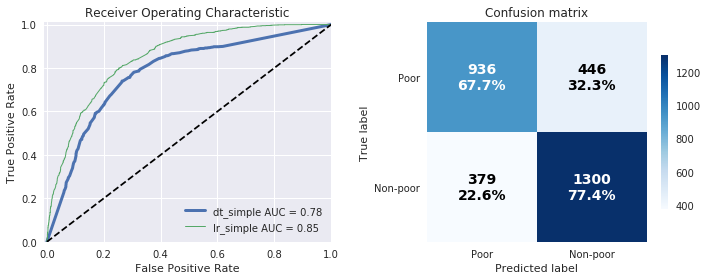

,dt_simple,lr_simple
accuracy,0.73048,0.766743
recall,0.677279,0.738784
precision,0.711787,0.743086
f1,0.694105,0.740929
cross_entropy,3.05841,0.478969
roc_auc,0.7789,0.847856
cohen_kappa,0.453494,0.528811


Actual poverty rate: 54.11% 
Predicted poverty rate: 54.74% 


In [5]:
from sklearn.tree import DecisionTreeClassifier

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, 
                                      selected_columns=selected_columns)

# Fit the model
model = DecisionTreeClassifier()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, 
                                   selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=feat_imps)

One very useful feature of Decision Tree Classifiers is that it provides feature importances, where all importances sum to 1.

In [6]:
feat_imps

,importance
der_nchild10under,0.233048
cons_0508__Yes,0.150817
der_nliterate,0.142080
der_nmalesover10,0.113728
der_nfemalesover10,0.104002
cons_0504__Yes,0.095851
der_nemployedpastyear,0.070820
hld_electricity__Yes,0.054816
hld_toilet__None,0.034838


## Decision Tree with all features <a class="anchor" id="all-feats"></a>

Now let's try using the full feature set

CPU times: user 611 ms, sys: 21.6 ms, total: 632 ms
Wall time: 632 ms
CPU times: user 17.4 ms, sys: 12.9 ms, total: 30.2 ms
Wall time: 29.7 ms
In-sample score: 100.00%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


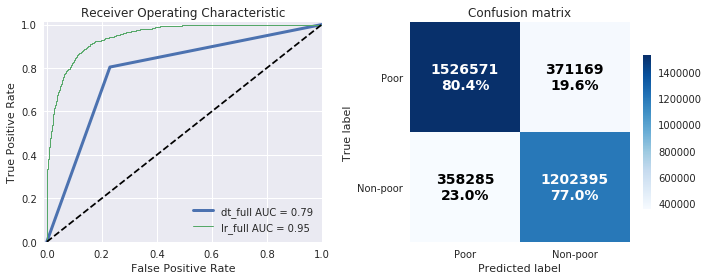

,dt_full,lr_full
accuracy,0.789079,0.873897
recall,0.804415,0.869754
precision,0.809914,0.853693
f1,0.807155,0.861649
cross_entropy,7.28504,0.288223
roc_auc,0.787423,0.948658
cohen_kappa,0.562185,0.745821


Actual poverty rate: 54.11% 
Predicted poverty rate: 54.02% 


In [7]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = DecisionTreeClassifier()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=feat_imps)

In this case, we have an in-sample score of 100%, yet the performance on the test set is not nearly as good as our baseline logistic regression classifier. This is a good example of over-fitting. The decision tree learner is creating overly-complex trees using the full feature set, so it fits very well to the training data, but does not generalize well to the test data.

There are several parameters available for us to help reduce these overfitting effects: We can limit the maximum depth of the tree, set a minimum number of samples per leaf, or set a minimum number of samples per split. Let's try a few example values for these parameters.

CPU times: user 542 ms, sys: 24.4 ms, total: 567 ms
Wall time: 567 ms
CPU times: user 23.6 ms, sys: 11.7 ms, total: 35.3 ms
Wall time: 35.3 ms
In-sample score: 91.68%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


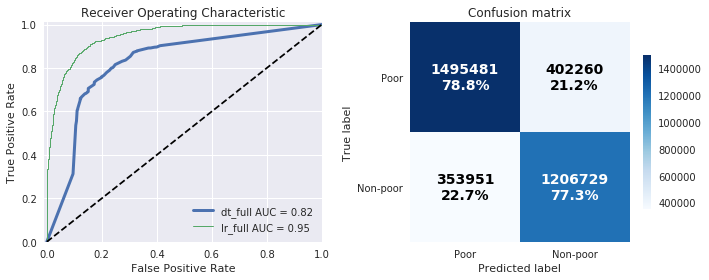

,dt_full,lr_full
accuracy,0.781342,0.873897
recall,0.788032,0.869754
precision,0.808616,0.853693
f1,0.798192,0.861649
cross_entropy,3.56614,0.288223
roc_auc,0.824372,0.948658
cohen_kappa,0.571708,0.745821


Actual poverty rate: 54.11% 
Predicted poverty rate: 53.39% 


In [8]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = DecisionTreeClassifier(max_depth=15, min_samples_leaf=5, min_samples_split=5)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=feat_imps)

We also have the option to include sample weights with this model

CPU times: user 616 ms, sys: 0 ns, total: 616 ms
Wall time: 1.26 s
CPU times: user 34.2 ms, sys: 0 ns, total: 34.2 ms
Wall time: 63.9 ms
In-sample score: 93.64%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


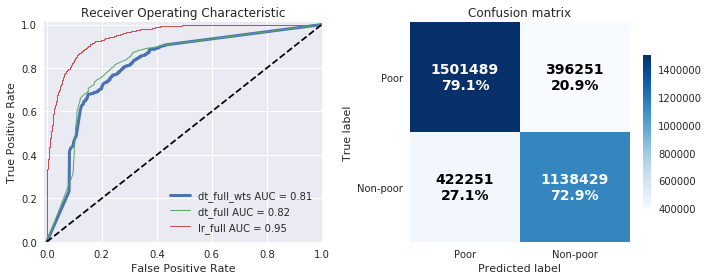

,dt_full_wts,dt_full,lr_full
accuracy,0.76333,0.781342,0.873897
recall,0.791198,0.788032,0.869754
precision,0.780505,0.808616,0.853693
f1,0.785815,0.798192,0.861649
cross_entropy,3.36897,3.56614,0.288223
roc_auc,0.814592,0.824372,0.948658
cohen_kappa,0.527538,0.571708,0.745821


Actual poverty rate: 54.11% 
Predicted poverty rate: 55.21% 


In [9]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = DecisionTreeClassifier(max_depth=15, min_samples_leaf=5, min_samples_split=5)
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['dt_full', 
                                                    'lr_full'],
                                    store_model=True,
                                    model_name='full_wts', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

The sample weights have a slight negative affect on performance. Rather than picking arbitrary values, we can try finding the best parameters using a grid search.

## Tune parameters and cross-validate <a class="anchor" id="tune-cv"></a>

The decision tree classifier model has several parameters we can tune, which could result in a large parameter grid if we attempt to apply the grid search method. One of the benefits of using a Decision Tree classifier is that is less computationally expensive than many other algorithms we have explored so far. This makes it more feasible for us to search a larger parameter grid for the best values. 

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.6s finished


CPU times: user 1.97 s, sys: 413 ms, total: 2.38 s
Wall time: 10.3 s
CPU times: user 22.6 ms, sys: 12.3 ms, total: 34.9 ms
Wall time: 35 ms
In-sample score: 83.15%
Best model parameters: {'max_depth': 11, 'min_samples_leaf': 41, 'min_samples_split': 2}


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


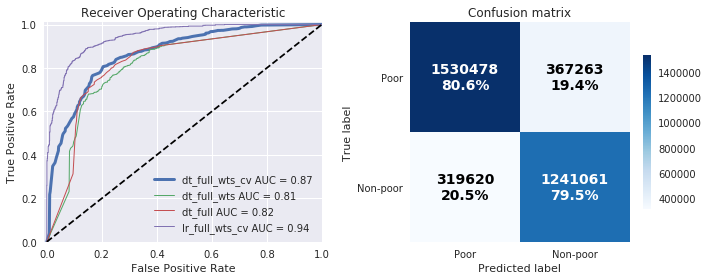

,dt_full_wts_cv,dt_full_wts,dt_full,lr_full_wts_cv
accuracy,0.801389,0.76333,0.781342,0.873458
recall,0.806474,0.791198,0.788032,0.891581
precision,0.827242,0.780505,0.808616,0.87947
f1,0.816726,0.785815,0.798192,0.885484
cross_entropy,0.633586,3.36897,3.56614,0.300498
roc_auc,0.867095,0.814592,0.824372,0.944474
cohen_kappa,0.619052,0.527538,0.571708,0.734446


Actual poverty rate: 54.11% 
Predicted poverty rate: 52.88% 


In [10]:
from sklearn.model_selection import GridSearchCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)


# build the model
estimator = DecisionTreeClassifier()
parameters = {'max_depth': np.arange(1,16,5), 
              'min_samples_split': np.arange(2,21,10),
              'min_samples_leaf': np.arange(1,46,20)
             }
fit_params = {'sample_weight': w_train}
model = GridSearchCV(estimator, parameters, fit_params=fit_params, verbose=1, cv=5, n_jobs=-1)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)
feat_imps = get_feat_imp_df(model.best_estimator_.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['dt_full_wts',
                                                    'dt_full', 
                                                    'lr_full_wts_cv'],
                                    store_model=True,
                                    model_name='full_wts_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)
best_model = model.best_estimator_

This gives us a noticeable boost in performance, with a better recall and much lower cross-entropy than the default model. 

# AdaBoost Decision Tree Classifier <a class="anchor" id="ada-boost"></a>

A popular method to improve the performance of decision tree classifiers is [AdaBoost](http://scikit-learn.org/stable/modules/ensemble.html#adaboost).

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 14.2min finished


CPU times: user 3min 24s, sys: 1.13 s, total: 3min 25s
Wall time: 21min 26s
CPU times: user 2.66 s, sys: 0 ns, total: 2.66 s
Wall time: 4.7 s
In-sample score: 99.59%
Best model parameters: {'learning_rate': 0.01, 'n_estimators': 400}


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


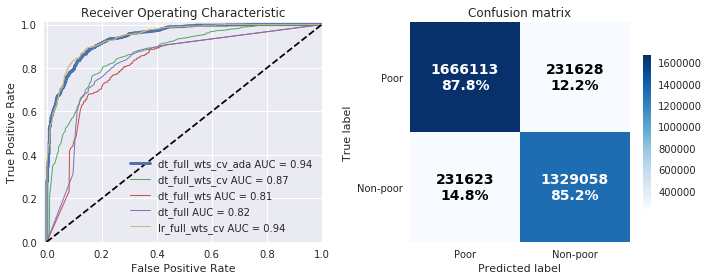

,dt_full_wts_cv_ada,dt_full_wts_cv,dt_full_wts,dt_full,lr_full_wts_cv
accuracy,0.866051,0.801389,0.76333,0.781342,0.873458
recall,0.877945,0.806474,0.791198,0.788032,0.891581
precision,0.877948,0.827242,0.780505,0.808616,0.87947
f1,0.877947,0.816726,0.785815,0.798192,0.885484
cross_entropy,0.353074,0.633586,3.36897,3.56614,0.300498
roc_auc,0.941477,0.867095,0.814592,0.824372,0.944474
cohen_kappa,0.737008,0.619052,0.527538,0.571708,0.734446


Actual poverty rate: 54.11% 
Predicted poverty rate: 54.38% 


In [11]:
from sklearn.ensemble import AdaBoostClassifier

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# build the model
estimator = AdaBoostClassifier(best_model)

parameters = {'n_estimators': [50, 100, 200, 400], 
              'learning_rate': [0.001, 0.01, .1, 1]
             }
fit_params = {'base_estimator__sample_weight': w_train}
model = GridSearchCV(estimator, parameters, verbose=1, cv=5, n_jobs=-1)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)
feat_imps = get_feat_imp_df(model.best_estimator_.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['dt_full_wts_cv', 
                                                    'dt_full_wts', 
                                                    'dt_full', 
                                                    'lr_full_wts_cv'],
                                    store_model=True,
                                    model_name='full_wts_cv_ada', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)
best_model = model.best_estimator_

Using AdaBoost gives us a significant performance increase, making this model nearly as good as our baseline logistic regression model. Let's inspect the top 20 features by importance:

In [12]:
feat_imps

,importance
der_hhsize,0.081713
der_nchild10under,0.025747
hld_rooms,0.019500
cons_0912__Yes,0.016564
cons_0508__Yes,0.014486
cons_0801__Yes,0.013867
cons_0602__Yes,0.013320
cons_0410__Yes,0.012593
cons_0302__Yes,0.012166
cons_0501__Yes,0.011779


# Feature selection <a class="anchor" id="feature-selection"></a>

Since this model provides feature importances, we can easily remove features that do not contribute much to the model. For example, we can filter our features to only those that contribute 90% of the model importance. In the case of filtering consumable features, we can quickly see which are most useful and filter it to the top 50 or less.

X shape after feature selection:  (9183, 153)
CPU times: user 1min 22s, sys: 197 ms, total: 1min 22s
Wall time: 2min 14s
CPU times: user 1.72 s, sys: 9.98 ms, total: 1.73 s
Wall time: 3.94 s
In-sample score: 99.56%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


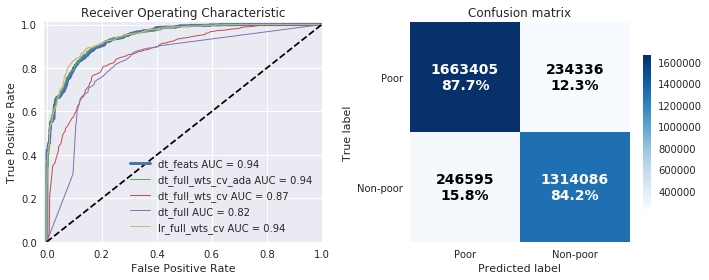

,dt_feats,dt_full_wts_cv_ada,dt_full_wts_cv,dt_full,lr_full_wts_cv
accuracy,0.860939,0.866051,0.801389,0.781342,0.873458
recall,0.876518,0.877945,0.806474,0.788032,0.891581
precision,0.870893,0.877948,0.827242,0.808616,0.87947
f1,0.873697,0.877947,0.816726,0.798192,0.885484
cross_entropy,0.352727,0.353074,0.633586,3.56614,0.300498
roc_auc,0.940489,0.941477,0.867095,0.824372,0.944474
cohen_kappa,0.73248,0.737008,0.619052,0.571708,0.734446


Actual poverty rate: 54.11% 
Predicted poverty rate: 54.52% 


In [13]:
feats = feat_imps[feat_imps.cumsum() <= 0.90].dropna().index.values

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=feats)
print("X shape after feature selection: ", X_train.shape)

# Fit the model
model = best_model
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=feats)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['dt_full_wts_cv_ada',
                                                    'dt_full_wts_cv', 
                                                    'dt_full', 
                                                    'lr_full_wts_cv'],
                                    store_model=True,
                                    model_name='feats', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

In [14]:
cons_feats = [x.split('__')[0] for x in feats if x[0:5] == 'cons_']
print("{} consumables features selected:".format(len(cons_feats)))
for x in cons_feats:
    print(questions[x])

81 consumables features selected:
Thobwa
Chicken
Sugar
Banana
Pumpkin
Bean, brown
Eggs
Maize ufa refined (fine flour)
Tea
Goat
Green maize
Dried fish
Rice
Groundnut flour
Bean, white
Public transport - Bus/Minibus
Fresh fish
Cooking oil
Donation - to church, charity, beggar, etc.
Cassava tubers
Groundnut
Maize ufa mgaiwa (normal flour)
Locally brewed liquor (kachasu)
Buns, scones
Cigarettes or other tobacco
Pork
Tanaposi/Rape
Clothes soap (powder)
Chitenje cloth
Paraffin or kerosene
Irish potato
Grass for thatching roof or other use
Bicycle service, repair, or parts
Guava
Bread
Small animal - rabbit, mice, etc.
Other personal products (shampoo, razor blades, cosmetics, hair products, etc.)
Toothpaste, toothbrush
Mandazi, doughnut (vendor)
Sugar Cane
Mat - sleeping or for drying maize flour
Smoked fish
White sweet potato
Girl's dress/skirt
Nkhwani
Bowls, glassware, plates, silverware, etc.
Boy's shoes
Beef
Funeral costs, nonhousehold members (relatives, neighbors/friends)
Repairs & main

# Decision Tree Classifier Malawi Summary <a class="anchor" id="summary"></a>



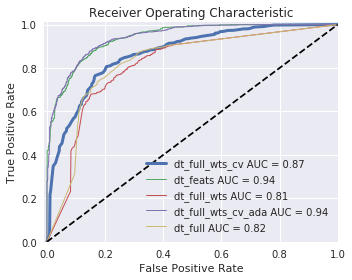

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
dt_full_wts_cv,0.801389,0.806474,0.827242,0.816726,0.633586,0.867095,0.619052,-0.012303
dt_feats,0.860939,0.876518,0.870893,0.873697,0.352727,0.940489,0.73248,0.00415969
dt_full_wts,0.76333,0.791198,0.780505,0.785815,3.36897,0.814592,0.527538,0.0110459
dt_full_wts_cv_ada,0.866051,0.877945,0.877948,0.877947,0.353074,0.941477,0.737008,0.00273764
dt_full,0.781342,0.788032,0.808616,0.798192,3.56614,0.824372,0.571708,-0.00718927


In [15]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)